## This program is made to track the rigid body variablity across the experimental protocol

In [1]:
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
sys.path.insert(0,'/Users/ashwin/Documents/Y4 project Brain Human Interfaces/General 4th year Github repo/BrainMachineInterfaces')

# Set the save game location
# Must have format of "../PointerExperimentData/Name_dd_mm__hh_mm_metadata" with no file extension
# saveFile = "../PointerExperimentData/Ashwin_13_02"
# saveGameLocation = saveFile + "/Ash_13_02_13_19" # must have format of "Name_dd_mm__hh_mm_metadata" with no file extension

from Experiment_pointer.runFullExperiment import saveDirectory, saveGameLocation

saveFile = saveDirectory

# Replace Experiment pointer with .. as notebook runs from another directory
saveFile = saveFile.replace("Experiment_pointer","..")
saveGameLocation = saveGameLocation.replace("Experiment_pointer","..")
path = "/Users/ashwin/Documents/Y4 project Brain Human Interfaces/General 4th year Github repo/BrainMachineInterfaces/Experiment_pointer/DataAnalysis"
os.chdir(path)

from Experiment_pointer.experimentFunctions import processTrialData
DOFOffset = 0.03
from sklearn.decomposition import PCA
from lib_streamAndRenderDataWorkflows.config_streaming import bodyParts


pygame 2.5.2 (SDL 2.28.3, Python 3.11.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# Fetch all trial information


rigidBodies1, cursorPos1,cursorVel1,goCues1,targetHits1,timeStamps1, minDof1,maxDof1,d = processTrialData(saveGameLocation + "_training1",DOFOffset)
rigidBodies2, cursorPos2,cursorVel2,goCues2,targetHits2,timeStamps2, minDof2,maxDof2,e = processTrialData(saveGameLocation + "_training2",DOFOffset)
rigidBodies3, cursorPos3,cursorVel3,goCues3,targetHits3,timeStamps3, minDof3,maxDof3,f = processTrialData(saveGameLocation + "_training3",DOFOffset)
rigidBodies4, cursorPos4,cursorVel4,goCues4,targetHits4,timeStamps4, minDof4,maxDof4,g = processTrialData(saveGameLocation + "_training4",DOFOffset)
rigidBodies5, cursorPos5,cursorVel5,goCues5,targetHits5,timeStamps5, minDof5,maxDof5,h = processTrialData(saveGameLocation + "_test",DOFOffset)# make this test 

/Users/ashwin/Documents/Y4 project Brain Human Interfaces/General 4th year Github repo/BrainMachineInterfaces/Experiment_pointer/DataAnalysis
/Users/ashwin/Documents/Y4 project Brain Human Interfaces/General 4th year Github repo/BrainMachineInterfaces/Experiment_pointer/DataAnalysis
/Users/ashwin/Documents/Y4 project Brain Human Interfaces/General 4th year Github repo/BrainMachineInterfaces/Experiment_pointer/DataAnalysis
/Users/ashwin/Documents/Y4 project Brain Human Interfaces/General 4th year Github repo/BrainMachineInterfaces/Experiment_pointer/DataAnalysis
/Users/ashwin/Documents/Y4 project Brain Human Interfaces/General 4th year Github repo/BrainMachineInterfaces/Experiment_pointer/DataAnalysis


In [3]:


def extractPCAFromRigidBodies(rigidBodyVector,cursorPos,useCursor = False):
    """
    Function that performs pca on each rigid body in rigid body vector to extract out main variations of each rigid body during trial
    """
    dimensionalityReducedRigidBodyVector = np.zeros((rigidBodyVector.shape[0],38))
    for rigidBodyIdx in range(0,19):

        
        # Retrieve current rigid body vector
        idxStart = rigidBodyIdx * 6
        idxEnd = idxStart + 6
        currRigidBody = rigidBodyVector[:,idxStart:idxEnd]
        rigidBodyPCA = PCA(n_components=2)
        X_new = rigidBodyPCA.fit_transform(currRigidBody)
        vars = rigidBodyPCA.explained_variance_ratio_
        if len(vars) == 2:
            print("Rigid Body: {}, variance explained in PC1: {}, and in PC2: {}".format(bodyParts[rigidBodyIdx],vars[0],vars[1]))
        elif len(vars) == 3:
            print("Rigid Body: {}, variance explained in PC1: {}, and in PC2: {} , and in PC3: {}".format(bodyParts[rigidBodyIdx],vars[0],vars[1],vars[2]))
        
        dimensionalityReducedRigidBodyVector[:,rigidBodyIdx*2:rigidBodyIdx*2+2] = X_new
        
    # Find the correlation coefficients between the right hand and other rigid odies
    bodiesCorrelationCoefficients = calcCorrelationCoefficients(dimensionalityReducedRigidBodyVector,cursorPos,useCursor = useCursor)


    outputDict = {
        "pca2RigidBodies" : dimensionalityReducedRigidBodyVector,
        "rigidBodiesCorrCoeffs" : bodiesCorrelationCoefficients

    }

    return outputDict


def calcCorrelationCoefficients(dimensionalityReducedRigidBodyVector,cursorPos,useCursor):

    """
    Calculates the correlation coefficients of the pca components
    """

    # Fetch Right hand principal component
    if not useCursor:
        rightHandPrincipalComponent = dimensionalityReducedRigidBodyVector[:,findBodyPart("RHand")[0]]
    else:
        print("Using cursor Position instead")
        rightHandPrincipalComponent = cursorPos[:,1]

    pearsonCoeffs = np.zeros(len(bodyParts))



    for idx,bodyPart in enumerate(bodyParts):
        # Fetch body part principal component
        bodyPartPrincipalComponent = dimensionalityReducedRigidBodyVector[:, findBodyPart(bodyPart)[0]]

        # Calculate correlation coefficient
        corrCoeff = np.corrcoef(rightHandPrincipalComponent,bodyPartPrincipalComponent)
        pearsonCoeffs[idx] = corrCoeff[0,1]

    return pearsonCoeffs

def findBodyPart(bodyPart):
    idx = bodyParts.index(bodyPart)
    return [idx, idx + 2]

def plotCorrelationCoefficientVariationAcrossTrial(rigidBodies,cursorPos,noRigidBodies = 19,discretisations = 10, trial = "1"):
    correlationCoefficientsInTrial = np.zeros((noRigidBodies,discretisations))
    totalLength = cursorPos.shape[0]
    sectionLength = totalLength // discretisations
    sectionStartTimes = []

    for i in range(discretisations):
        lowerBound = i * sectionLength
        upperBound = lowerBound + sectionLength
        outputDictPCAVectors = extractPCAFromRigidBodies(rigidBodies[lowerBound:upperBound,:],cursorPos[lowerBound:upperBound,:])
        print(correlationCoefficientsInTrial.shape)
        correlationCoefficientsInTrial[:,i] = outputDictPCAVectors['rigidBodiesCorrCoeffs']
        sectionStartTimes.append(timeStamps1[lowerBound] // 1000)

    sns.heatmap(correlationCoefficientsInTrial, cmap = cmap, yticklabels = bodyParts, xticklabels= sectionStartTimes)

    plt.title("Heatmap of rigid body correlation coefficients in trial " + trial)
    plt.xlabel("Section start time (s)", fontsize = 15)
    plt.ylabel("Correlation Coerfficient", fontsize = 15)
    plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trial " + trial)

    return correlationCoefficientsInTrial


Rigid Body: Pelvis, variance explained in PC1: 0.5173443801946362, and in PC2: 0.39723869031037146
Rigid Body: Ab, variance explained in PC1: 0.51807730282736, and in PC2: 0.41828598027681724
Rigid Body: Chest, variance explained in PC1: 0.5112573880285927, and in PC2: 0.26421925268188906
Rigid Body: Neck, variance explained in PC1: 0.5868350834726388, and in PC2: 0.3223106519822404
Rigid Body: Head, variance explained in PC1: 0.48523390127555427, and in PC2: 0.3765529740923752
Rigid Body: LShoulder, variance explained in PC1: 0.48671068066136247, and in PC2: 0.3015570565614976
Rigid Body: LUArm, variance explained in PC1: 0.5596418876776236, and in PC2: 0.20412501464918612
Rigid Body: LFArm, variance explained in PC1: 0.6761858970874086, and in PC2: 0.18431480626080168
Rigid Body: LHand, variance explained in PC1: 0.7187449878622487, and in PC2: 0.1444086930856614
Rigid Body: RShoulder, variance explained in PC1: 0.4755367031199395, and in PC2: 0.2731922403279662
Rigid Body: RUArm, va

/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_67831/4187280098.py:57: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trainingPhase")
/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_67831/4187280098.py:57: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trainingPhase")
/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_67831/4187280098.py:57: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trainingP

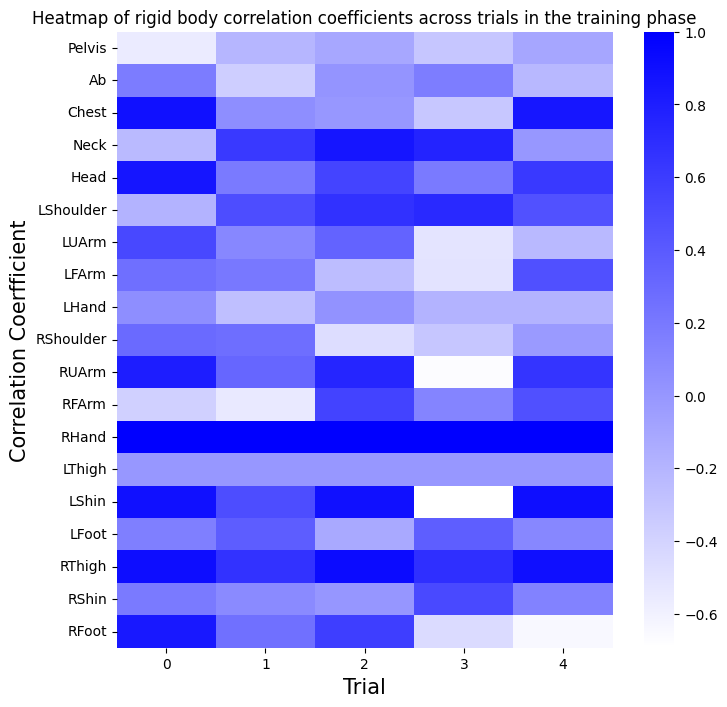

In [4]:
# Set parameters
trials = 5
rigidBodies = 19



# Pass the correct trial to the timestamp vector in seconds
timeStampVector =  timeStamps1  / 1000 #

correlationCoefficientsAcrossTrials = np.zeros((rigidBodies,trials))

# Analyse biggest PC of each rigid body trial 1 (training)
outputDictPCAVectorsTrial1 = extractPCAFromRigidBodies(rigidBodies1,cursorPos1)

# Analyse biggest PC of each rigid body trial 2 (training)
outputDictPCAVectorsTrial2 = extractPCAFromRigidBodies(rigidBodies2,cursorPos2)

# Analyse biggest PC of each rigid body trial 3 (training)
outputDictPCAVectorsTrial3 = extractPCAFromRigidBodies(rigidBodies3,cursorPos3)

# Analyse biggest PC of each rigid body trial 4 (training)
outputDictPCAVectorsTrial4 = extractPCAFromRigidBodies(rigidBodies4,cursorPos4)

# Analyse biggest PC of each rigid body trial 5 (test)
outputDictPCAVectorsTrial5 = extractPCAFromRigidBodies(rigidBodies5,cursorPos5)

# Collate all correlation coefficients to measure the evolution
correlationCoefficientsAcrossTrials[:,0] = outputDictPCAVectorsTrial1['rigidBodiesCorrCoeffs']
correlationCoefficientsAcrossTrials[:,1] = outputDictPCAVectorsTrial2['rigidBodiesCorrCoeffs']
correlationCoefficientsAcrossTrials[:,2] = outputDictPCAVectorsTrial3['rigidBodiesCorrCoeffs']
correlationCoefficientsAcrossTrials[:,3] = outputDictPCAVectorsTrial4['rigidBodiesCorrCoeffs']
correlationCoefficientsAcrossTrials[:,4] = outputDictPCAVectorsTrial5['rigidBodiesCorrCoeffs']

# # Plot rigid body correlation coefficients
# plt.plot(correlationCoefficientsAcrossTrials.transpose())
# plt.show()

# plt.imshow(correlationCoefficientsAcrossTrials, interpolation='nearest')
# plt.colorbar()  # To show the scale
# plt.show()

import seaborn as sns

from matplotlib.colors import LinearSegmentedColormap

# Define the colors
colors = ["#ffffff","#0000ff"]  # Blue to white to red

# Create the colormap
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors )
plt.figure(figsize=(8, 8)) 
sns.heatmap(correlationCoefficientsAcrossTrials, cmap = cmap, yticklabels = bodyParts)

plt.title("Heatmap of rigid body correlation coefficients across trials in the training phase")
plt.xlabel("Trial", fontsize = 15)
plt.ylabel("Correlation Coerfficient", fontsize = 15)
plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trainingPhase")

Rigid Body: Pelvis, variance explained in PC1: 0.6277877422016103, and in PC2: 0.35764582790897803
Rigid Body: Ab, variance explained in PC1: 0.8203130030105639, and in PC2: 0.17829775647804985
Rigid Body: Chest, variance explained in PC1: 0.7052506788204695, and in PC2: 0.269062859445251
Rigid Body: Neck, variance explained in PC1: 0.7143415997946891, and in PC2: 0.2736693258771028
Rigid Body: Head, variance explained in PC1: 0.7890169840957839, and in PC2: 0.1862655671571929
Rigid Body: LShoulder, variance explained in PC1: 0.751301042932315, and in PC2: 0.1980388663499866
Rigid Body: LUArm, variance explained in PC1: 0.8064648818942566, and in PC2: 0.18503144045109296
Rigid Body: LFArm, variance explained in PC1: 0.7523773452903163, and in PC2: 0.23950576548138858
Rigid Body: LHand, variance explained in PC1: 0.7633480483759255, and in PC2: 0.23020486621394837
Rigid Body: RShoulder, variance explained in PC1: 0.8584481003994451, and in PC2: 0.10537287839342559
Rigid Body: RUArm, var

/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_67831/2092727537.py:86: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trial " + trial)
/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_67831/2092727537.py:86: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trial " + trial)
/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_67831/2092727537.py:86: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trial "

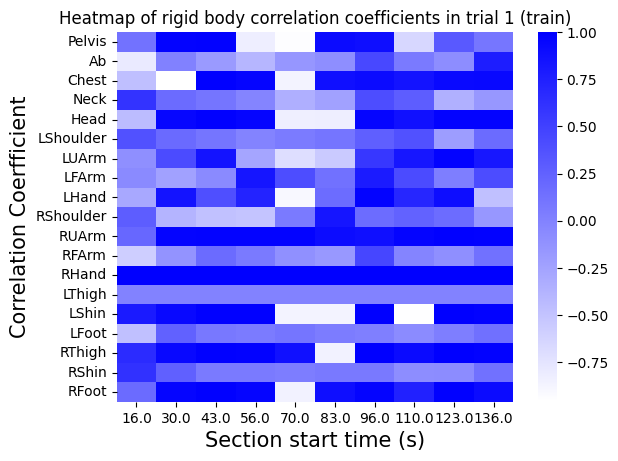

Rigid Body: Pelvis, variance explained in PC1: 0.7039879381691979, and in PC2: 0.2932157240705125
Rigid Body: Ab, variance explained in PC1: 0.6564843227787115, and in PC2: 0.34209521416375227
Rigid Body: Chest, variance explained in PC1: 0.7245544001334071, and in PC2: 0.24211480237826505
Rigid Body: Neck, variance explained in PC1: 0.8291161838337971, and in PC2: 0.16636818418731064
Rigid Body: Head, variance explained in PC1: 0.8710223081887124, and in PC2: 0.11413892006852865
Rigid Body: LShoulder, variance explained in PC1: 0.7724647721925715, and in PC2: 0.17672904240069987
Rigid Body: LUArm, variance explained in PC1: 0.9093706784493494, and in PC2: 0.08741953502814505
Rigid Body: LFArm, variance explained in PC1: 0.8591927872660506, and in PC2: 0.13866010172828527
Rigid Body: LHand, variance explained in PC1: 0.8633555686618072, and in PC2: 0.13467004478114725
Rigid Body: RShoulder, variance explained in PC1: 0.7784048423215474, and in PC2: 0.20809078074579931
Rigid Body: RUArm

/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_67831/2092727537.py:86: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trial " + trial)
/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_67831/2092727537.py:86: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trial " + trial)
/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_67831/2092727537.py:86: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trial "

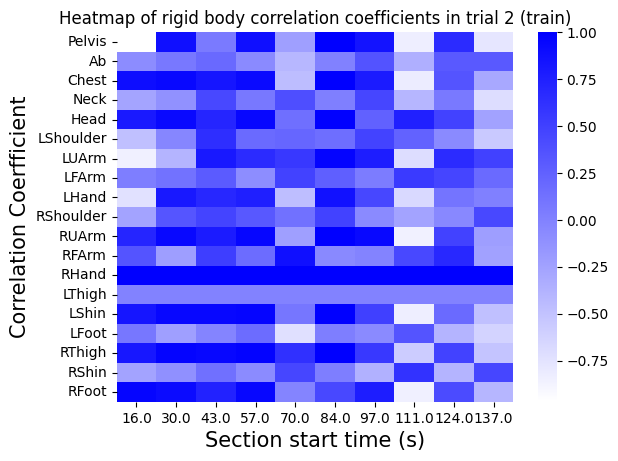

Rigid Body: Pelvis, variance explained in PC1: 0.700558152080363, and in PC2: 0.2143711904767624
Rigid Body: Ab, variance explained in PC1: 0.7558837712199644, and in PC2: 0.15031241655121996
Rigid Body: Chest, variance explained in PC1: 0.677494678307353, and in PC2: 0.22470558615100816
Rigid Body: Neck, variance explained in PC1: 0.7763830553557153, and in PC2: 0.1469040042071131
Rigid Body: Head, variance explained in PC1: 0.5538373674429768, and in PC2: 0.33047287671595904
Rigid Body: LShoulder, variance explained in PC1: 0.4852200780701362, and in PC2: 0.26092816939111857
Rigid Body: LUArm, variance explained in PC1: 0.43451510096507906, and in PC2: 0.3273062058613892
Rigid Body: LFArm, variance explained in PC1: 0.5606278254103341, and in PC2: 0.29235402398596766
Rigid Body: LHand, variance explained in PC1: 0.6241476362563315, and in PC2: 0.2868245247433043
Rigid Body: RShoulder, variance explained in PC1: 0.7937470864522835, and in PC2: 0.1991908642474576
Rigid Body: RUArm, var

/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_67831/2092727537.py:86: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trial " + trial)
/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_67831/2092727537.py:86: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trial " + trial)
/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_67831/2092727537.py:86: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trial "

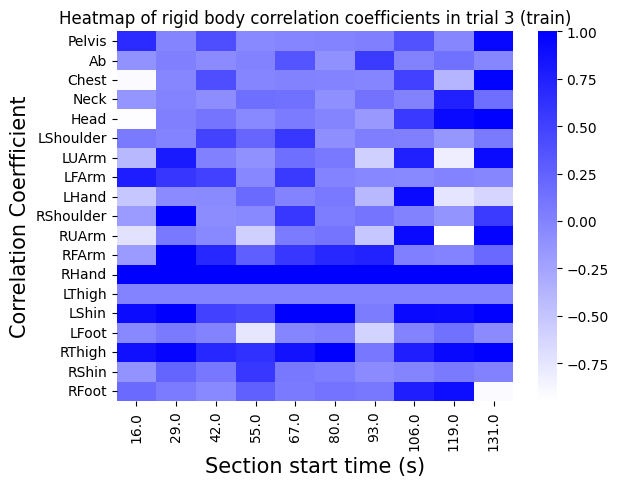

Rigid Body: Pelvis, variance explained in PC1: 0.9386093923471295, and in PC2: 0.04047232586782016
Rigid Body: Ab, variance explained in PC1: 0.7722976841043541, and in PC2: 0.21543395297398268
Rigid Body: Chest, variance explained in PC1: 0.7069442165522012, and in PC2: 0.2335288579074785
Rigid Body: Neck, variance explained in PC1: 0.7401862342236321, and in PC2: 0.2492848665628257
Rigid Body: Head, variance explained in PC1: 0.8582171252465516, and in PC2: 0.11291642943949541
Rigid Body: LShoulder, variance explained in PC1: 0.8001315184431728, and in PC2: 0.13685017491204327
Rigid Body: LUArm, variance explained in PC1: 0.8086882131730116, and in PC2: 0.16279457361852417
Rigid Body: LFArm, variance explained in PC1: 0.7303952449679175, and in PC2: 0.25552975631134855
Rigid Body: LHand, variance explained in PC1: 0.5693354733283228, and in PC2: 0.4058280615124292
Rigid Body: RShoulder, variance explained in PC1: 0.8088128833956657, and in PC2: 0.114138887232068
Rigid Body: RUArm, va

/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_67831/2092727537.py:86: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trial " + trial)
/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_67831/2092727537.py:86: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trial " + trial)
/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_67831/2092727537.py:86: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trial "

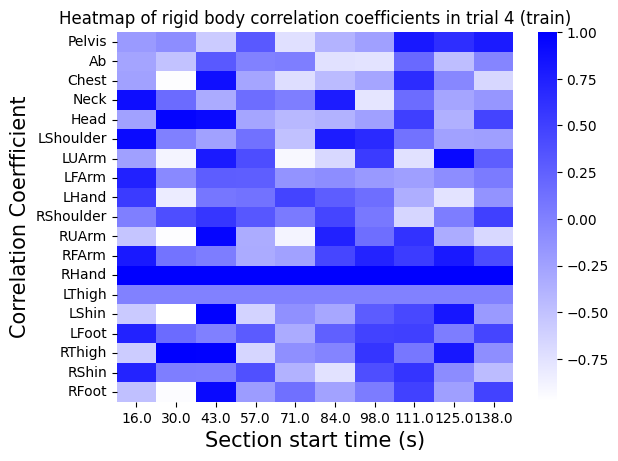

Rigid Body: Pelvis, variance explained in PC1: 0.9584560013985598, and in PC2: 0.03323028667897071
Rigid Body: Ab, variance explained in PC1: 0.6769764892689393, and in PC2: 0.31961778720237216
Rigid Body: Chest, variance explained in PC1: 0.672149691451885, and in PC2: 0.31231839797095706
Rigid Body: Neck, variance explained in PC1: 0.7152349847250964, and in PC2: 0.27905861841845947
Rigid Body: Head, variance explained in PC1: 0.9420173374908839, and in PC2: 0.043898134658256614
Rigid Body: LShoulder, variance explained in PC1: 0.5602938155901751, and in PC2: 0.42528824832859774
Rigid Body: LUArm, variance explained in PC1: 0.7293950820633889, and in PC2: 0.26485312271788797
Rigid Body: LFArm, variance explained in PC1: 0.6928300277753615, and in PC2: 0.3009117128440426
Rigid Body: LHand, variance explained in PC1: 0.7167272057637849, and in PC2: 0.2753985914721012
Rigid Body: RShoulder, variance explained in PC1: 0.6901726113652826, and in PC2: 0.293693789366632
Rigid Body: RUArm, v

/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_67831/2092727537.py:86: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trial " + trial)
/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_67831/2092727537.py:86: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trial " + trial)
/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_67831/2092727537.py:86: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trial "

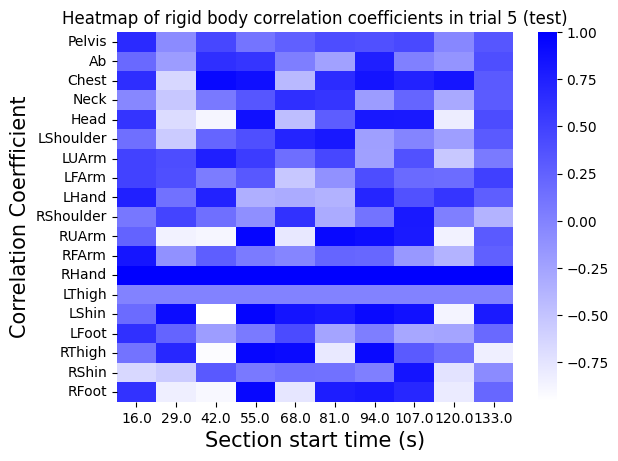

In [5]:
# Plot the correlation over a trial

plotCorrelationCoefficientVariationAcrossTrial(rigidBodies1,cursorPos1,trial = "1 (train)")
plt.show()
plotCorrelationCoefficientVariationAcrossTrial(rigidBodies2,cursorPos2,trial = "2 (train)")
plt.show()
plotCorrelationCoefficientVariationAcrossTrial(rigidBodies3,cursorPos3,trial = "3 (train)")
plt.show()
plotCorrelationCoefficientVariationAcrossTrial(rigidBodies4,cursorPos4,trial = "4 (train)")
plt.show()
plotCorrelationCoefficientVariationAcrossTrial(rigidBodies5,cursorPos5,trial = "5 (test)")
plt.show()

In [6]:
# Now look at learning over the decoder period



rigidBodiesE, cursorPosE,cursorVelE,goCuesE,targetHitsE,timeStampsE, minDofE,maxDofE,e = processTrialData(saveGameLocation + "_usingDecoderE",DOFOffset)
rigidBodiesF, cursorPosF,cursorVelF,goCuesF,targetHitsF,timeStampsF, minDofF,maxDofF,f = processTrialData(saveGameLocation + "_usingDecoderF",DOFOffset)
rigidBodiesG, cursorPosG,cursorVelG,goCuesG,targetHitsG,timeStampsG, minDofG,maxDofG,g = processTrialData(saveGameLocation + "_usingDecoderG",DOFOffset)
rigidBodiesH, cursorPosH,cursorVelH,goCuesH,targetHitsH,timeStampsH, minDofH,maxDofH,h = processTrialData(saveGameLocation + "_usingDecoderH",DOFOffset)
rigidBodiesI, cursorPosI,cursorVelI,goCuesI,targetHitsI,timeStampsI, minDofI,maxDofI,i = processTrialData(saveGameLocation + "_usingDecoderI",DOFOffset)
rigidBodiesJ, cursorPosJ,cursorVelJ,goCuesJ,targetHitsJ,timeStampsJ, minDofJ,maxDofJ,j = processTrialData(saveGameLocation + "_usingDecoderJ",DOFOffset)

/Users/ashwin/Documents/Y4 project Brain Human Interfaces/General 4th year Github repo/BrainMachineInterfaces/Experiment_pointer/DataAnalysis
/Users/ashwin/Documents/Y4 project Brain Human Interfaces/General 4th year Github repo/BrainMachineInterfaces/Experiment_pointer/DataAnalysis
/Users/ashwin/Documents/Y4 project Brain Human Interfaces/General 4th year Github repo/BrainMachineInterfaces/Experiment_pointer/DataAnalysis
/Users/ashwin/Documents/Y4 project Brain Human Interfaces/General 4th year Github repo/BrainMachineInterfaces/Experiment_pointer/DataAnalysis
/Users/ashwin/Documents/Y4 project Brain Human Interfaces/General 4th year Github repo/BrainMachineInterfaces/Experiment_pointer/DataAnalysis
/Users/ashwin/Documents/Y4 project Brain Human Interfaces/General 4th year Github repo/BrainMachineInterfaces/Experiment_pointer/DataAnalysis


Rigid Body: Pelvis, variance explained in PC1: 0.903247256944571, and in PC2: 0.05635239046528188
Rigid Body: Ab, variance explained in PC1: 0.840141361952469, and in PC2: 0.12529967055700783
Rigid Body: Chest, variance explained in PC1: 0.9342332668185509, and in PC2: 0.041722193971436713
Rigid Body: Neck, variance explained in PC1: 0.6372166508787258, and in PC2: 0.28799991393398666
Rigid Body: Head, variance explained in PC1: 0.7573360582542282, and in PC2: 0.20615705866477163
Rigid Body: LShoulder, variance explained in PC1: 0.8737170363758668, and in PC2: 0.10007990176267542
Rigid Body: LUArm, variance explained in PC1: 0.6504161049081969, and in PC2: 0.27097081352472796
Rigid Body: LFArm, variance explained in PC1: 0.8410958916409541, and in PC2: 0.1239393420449643
Rigid Body: LHand, variance explained in PC1: 0.8239671765243181, and in PC2: 0.13451841005286136
Rigid Body: RShoulder, variance explained in PC1: 0.9220650102546898, and in PC2: 0.057039986333412326
Rigid Body: RUArm

/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_67831/4068059672.py:61: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trainingPhase")
/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_67831/4068059672.py:61: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trainingPhase")
/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_67831/4068059672.py:61: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trainingP

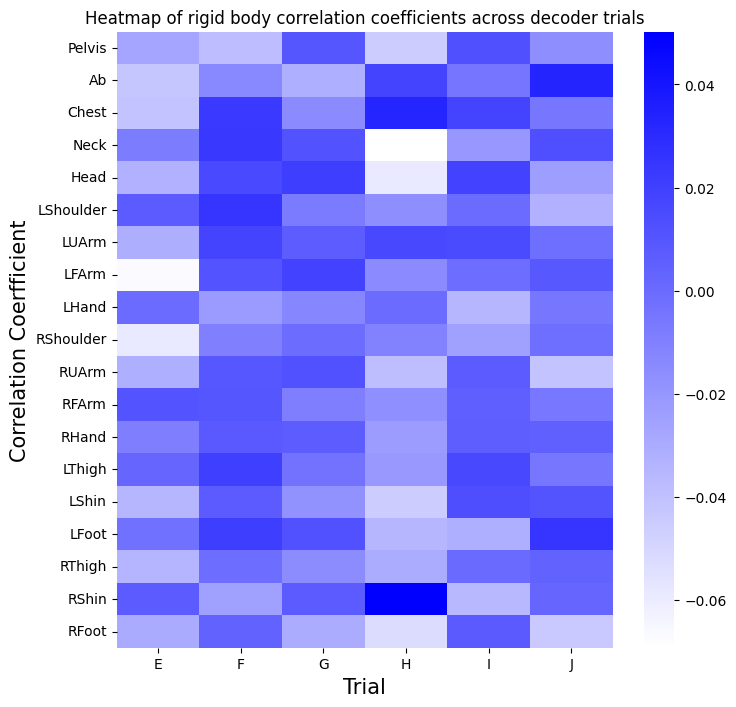

In [7]:
# Set parameters
trials = 6
rigidBodies = 19



# Pass the correct trial to the timestamp vector in seconds
timeStampVector =  timeStamps1  / 1000 #

correlationCoefficientsAcrossTrials = np.zeros((rigidBodies,trials))

# Analyse biggest PC of each rigid body trial E
outputDictPCAVectorsTrialE = extractPCAFromRigidBodies(rigidBodiesE,cursorPosE,useCursor = True)

# Analyse biggest PC of each rigid body trial F
outputDictPCAVectorsTrialF = extractPCAFromRigidBodies(rigidBodiesF,cursorPosF,useCursor = True)

# Analyse biggest PC of each rigid body trial G
outputDictPCAVectorsTrialG = extractPCAFromRigidBodies(rigidBodiesG,cursorPosG,useCursor = True)

# Analyse biggest PC of each rigid body trial H
outputDictPCAVectorsTrialH = extractPCAFromRigidBodies(rigidBodiesH,cursorPosH,useCursor = True)

# Analyse biggest PC of each rigid body trial I
outputDictPCAVectorsTrialI = extractPCAFromRigidBodies(rigidBodiesI,cursorPosI,useCursor = True)

# Analyse biggest PC of each rigid body trial J 
outputDictPCAVectorsTrialJ = extractPCAFromRigidBodies(rigidBodiesJ,cursorPosJ,useCursor = True)

# Collate all correlation coefficients to measure the evolution
correlationCoefficientsAcrossTrials[:,0] = outputDictPCAVectorsTrialE['rigidBodiesCorrCoeffs']
correlationCoefficientsAcrossTrials[:,1] = outputDictPCAVectorsTrialF['rigidBodiesCorrCoeffs']
correlationCoefficientsAcrossTrials[:,2] = outputDictPCAVectorsTrialG['rigidBodiesCorrCoeffs']
correlationCoefficientsAcrossTrials[:,3] = outputDictPCAVectorsTrialH['rigidBodiesCorrCoeffs']
correlationCoefficientsAcrossTrials[:,4] = outputDictPCAVectorsTrialI['rigidBodiesCorrCoeffs']
correlationCoefficientsAcrossTrials[:,5] = outputDictPCAVectorsTrialJ['rigidBodiesCorrCoeffs']

# # Plot rigid body correlation coefficients
# plt.plot(correlationCoefficientsAcrossTrials.transpose())
# plt.show()

# plt.imshow(correlationCoefficientsAcrossTrials, interpolation='nearest')
# plt.colorbar()  # To show the scale
# plt.show()

import seaborn as sns

from matplotlib.colors import LinearSegmentedColormap

# Define the colors
colors = ["#ffffff","#0000ff"]  # Blue to white to red
decoders = ['E','F','G','H','I','J']
# Create the colormap
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors )
plt.figure(figsize=(8, 8)) 
sns.heatmap(correlationCoefficientsAcrossTrials, cmap = cmap, yticklabels = bodyParts, xticklabels=decoders)

plt.title("Heatmap of rigid body correlation coefficients across decoder trials")
plt.xlabel("Trial", fontsize = 15)
plt.ylabel("Correlation Coerfficient", fontsize = 15)
plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trainingPhase")